In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn
import missingno as msno
from pathlib import Path
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
%matplotlib inline

차후에 보여줄 텍스트 설정

In [2]:
index=["default","Pearson","model"] 
column = ["RBPrecision","RBRecall","RBf1","RBcolumns","GBPrecision","GBRecall","GBf1","GBcolumns","XGBPrecision","XGBRecall","XGBf1","XGBcolumns"]
table = pd.DataFrame(index = index,columns=column)
display(pd.DataFrame(table))

,RBPrecision,RBRecall,RBf1,RBcolumns,GBPrecision,GBRecall,GBf1,GBcolumns,XGBPrecision,XGBRecall,XGBf1,XGBcolumns
default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 데이터 업로드

In [3]:
if not Path("/content/MachingLearningHomeWork/Project/data").exists():
  !git clone --depth 1 https://github.com/jsuk10/MachingLearningHomeWork.git
os.listdir("/content/MachingLearningHomeWork/Project/data")
datapwd = "/content/MachingLearningHomeWork/Project/data"
train = pd.read_csv (datapwd+"/train.csv") 
test = pd.read_csv (datapwd+"/test.csv")
train.head()


Cloning into 'MachingLearningHomeWork'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 76 (delta 2), reused 66 (delta 1), pack-reused 0
Unpacking objects: 100% (76/76), done.


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


# 결손치(null값) 확인
각원소들의 count를 비교하고 확인했으나 이상없음
만약 결손이 난다면
train['칼럼이름'].unique()로 다시 확인할 수 있다.


In [4]:
train.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [5]:
test.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000
mean,12987.500000,65005.657992,39.620958,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857
std,7498.769632,37611.526647,15.135685,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539
min,0.000000,17.000000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,6493.750000,32170.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000
50%,12987.500000,65319.500000,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000
75%,19481.250000,97584.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000
max,25975.000000,129877.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000


In [6]:
train = train.fillna(0)
test = test.fillna(0)
train.drop(['id','Unnamed: 0'], axis=1, inplace=True)
test.drop(['id','Unnamed: 0'], axis=1, inplace=True)

# 소비자 타입 그래프로 확인

80:18퍼센트 과하게 몰려있지는 않다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


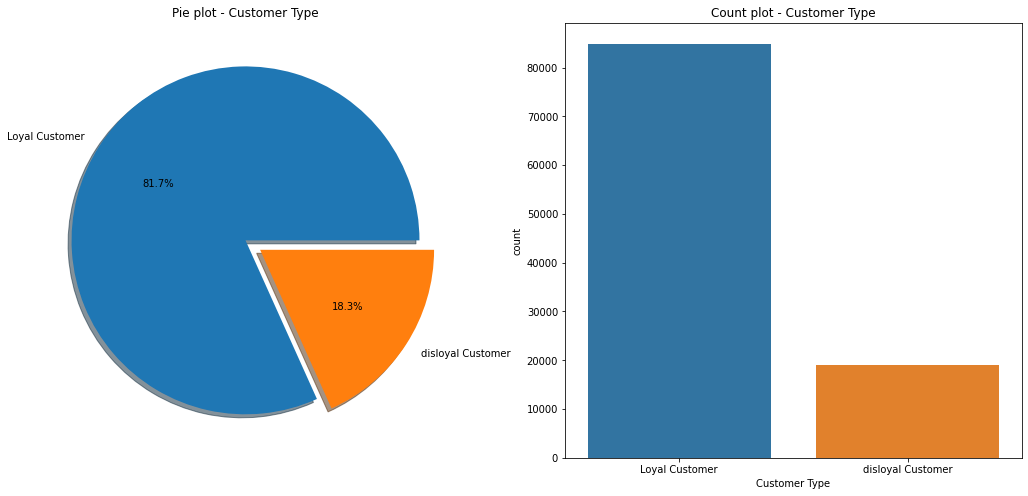

In [7]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

train['Customer Type'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Customer Type')
ax[0].set_ylabel('')
sns.countplot('Customer Type', data=train, ax=ax[1])
ax[1].set_title('Count plot - Customer Type')

plt.show()

# 데이터 정제
수치 flaot화 하고 maping해준다.

In [8]:
train.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [9]:
# 코드들 분포도 확인
# 그룹화 할 영역과 숫자형이 아닌 영역을 변환해준다
train.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [10]:
train['Gender'].isnull().any() , train['Class'].dtypes

(False, dtype('O'))

In [11]:
# 비지니스 타입
train['Customer Type'] = train['Customer Type'].map({'disloyal Customer': 0, 'Loyal Customer': 1})
test['Customer Type'] = test['Customer Type'].map({'disloyal Customer': 0, 'Loyal Customer': 1})
# 성별
train['Gender'] = train['Gender'].map({'Female': 0, 'Male': 1})
test['Gender'] = test['Gender'].map({'Female': 0, 'Male': 1})
# Class
train['Class'] = train['Class'].map({'Eco Plus': 0, 'Business': 1,'Eco':2})
test['Class'] = test['Class'].map({'Eco Plus': 0, 'Business': 1,'Eco':2})
# Type of Travel
train['Type of Travel'] = train['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})
test['Type of Travel'] = test['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})
# satisfaction
train['satisfaction'] = train['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
test['satisfaction'] = test['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})


In [12]:
# 나이
def categoryAge(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 40:
        return 2
    elif x < 60:
        return 3
    else:
        return 4
train['Age'] = train['Age'].apply(categoryAge)
test['Age'] = test['Age'].apply(categoryAge)

In [13]:
# 훈련 데이터의 4분할 점에 해당하는 점이 414 843 1743이므로
# 각 500, 1000, 2000, 이상으로 분류
def categoryFlightDistance(x):
    if x < 500:
        return 0
    elif x < 1000:
        return 1
    elif x < 2000:
        return 2
    else:
        return 3
  
train['Flight Distance'] = train['Flight Distance'].apply(categoryFlightDistance)
test['Flight Distance'] = test['Flight Distance'].apply(categoryFlightDistance)

In [14]:
# 딜레이 묶음
# 평균 15의 딜레이를 지니고 있으므로
# less(5미만) nomal(20미만) much(20이상으로 그룹화)
def categoryDelay(x):
    if x < 5:
        return 0
    elif x < 20:
        return 1
    else:
        return 2

train['Departure Delay in Minutes'] = train['Departure Delay in Minutes'].apply(categoryDelay)
test['Departure Delay in Minutes'] = test['Departure Delay in Minutes'].apply(categoryDelay)
train['Arrival Delay in Minutes'] = train['Arrival Delay in Minutes'].apply(categoryDelay)
test['Arrival Delay in Minutes'] = test['Arrival Delay in Minutes'].apply(categoryDelay)

In [15]:
train['Gender'].isnull().any() , train['Class'].dtypes

(False, dtype('int64'))

In [16]:
test['Gender'].isnull().any() , test['Class'].dtypes

(False, dtype('int64'))

In [17]:
# 확인
train.describe()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,0.492541,0.817322,2.486314,0.689627,1.377762,1.318756,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,0.542337,0.556552,0.433333
std,0.499947,0.386404,0.835880,0.462649,0.615882,1.117380,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,0.798144,0.801201,0.495538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,4.000000,1.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,1.000000


In [18]:
test.describe()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000
mean,0.492917,0.815253,2.499731,0.694410,1.371381,1.326455,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,0.537265,0.554897,0.438982
std,0.499959,0.388100,0.832636,0.460666,0.617308,1.117774,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,0.794251,0.801243,0.496272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,4.000000,1.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,1.000000


# 모델학습
현재 Customer Type은 1(Loyal Customer) , 0(disloyal Customer)로 이루어져 있다.
그러기 때문에 binary classfication문제로 해석된다.


## 성능 평가
또한 성능은 아래와 같이 혼돈행렬을 통한 재현율(Recall)과 정밀도(sprecision)로 평가한다

$$혼돈행렬 = \begin{bmatrix}
& &예측 &클래스 \\
실제 & & Negative & Positive \\
클래스 &Negative & TN & FP \\
&Positive & FN & TP
\end{bmatrix}$$$$민감도 = {TP\over TP + FN}$$
$$정밀도 = {TP\over TP+FP}$$

# 특성 중요도 저장할 테이블 제작


In [19]:
importanceindex=["Peterson","RPdefault","RPPearson","RPmodel","GBdefault","GBPearson","GBmodel","XGBdefault","XGBPearson","XGBmodel"] 
importancecolumn = []
importancetableIndex =1
for a in range(1,11):
  importancecolumn.append(a)
importanceTable = pd.DataFrame(index = importanceindex,columns=importancecolumn)
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 랜덤 포레스트(디폴트값)

In [20]:
# 패키지 임포트
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [21]:
X_train = train.drop('Customer Type', axis=1).values
target_label = train['Customer Type'].values
X_test = test.drop('Customer Type', axis=1).values
test.drop('Customer Type', axis=1, inplace=True)
X_train.shape, X_test.shape

((103904, 22), (25976, 22))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_train, target_label, test_size=0.2, random_state=42)

In [23]:
# null체크
np.where(np.isnan(X_train))

(array([], dtype=int64), array([], dtype=int64))

In [24]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [25]:
rpmatrix = confusion_matrix(y_test, prediction)
print(rpmatrix)
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train,y_train)*100))
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test,y_test)*100))
print('{:.4f}% 정밀도로 고객을 예측함'.format(rpmatrix[1][1]/(rpmatrix[1][1]+rpmatrix[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(rpmatrix[1][1]/(rpmatrix[1][1]+rpmatrix[0][1])*100))
# 저장
table["RBPrecision"][index[0]] = rpmatrix[1][1]/(rpmatrix[1][1]+rpmatrix[1][0])*100
table["RBRecall"][index[0]] = rpmatrix[1][1]/(rpmatrix[1][1]+rpmatrix[0][1])*100
table["RBcolumns"][index[0]] = train.columns.size-1

[[ 3558   217]
 [   62 16944]]
훈련 세트 정확도: 99.998
테스트 세트 정확도: 98.657
99.6354% 정밀도로 고객을 예측함
98.7355% 재현률로 고객을 예측함


랜덤 포레스트에 사용된 가중치를 보기

In [26]:
train.columns.size

23

Type of Travel                       0.187068
Departure/Arrival time convenient    0.085868
Age                                  0.084369
Ease of Online booking               0.066492
Online boarding                      0.063193
Gate location                        0.055366
satisfaction                         0.052180
Class                                0.048119
Inflight wifi service                0.045885
Flight Distance                      0.045390
Inflight entertainment               0.036987
Inflight service                     0.032226
Seat comfort                         0.032188
Baggage handling                     0.030367
Cleanliness                          0.027213
On-board service                     0.022583
Food and drink                       0.022015
Checkin service                      0.021951
Leg room service                     0.018376
Gender                               0.008836
Arrival Delay in Minutes             0.006994
Departure Delay in Minutes        

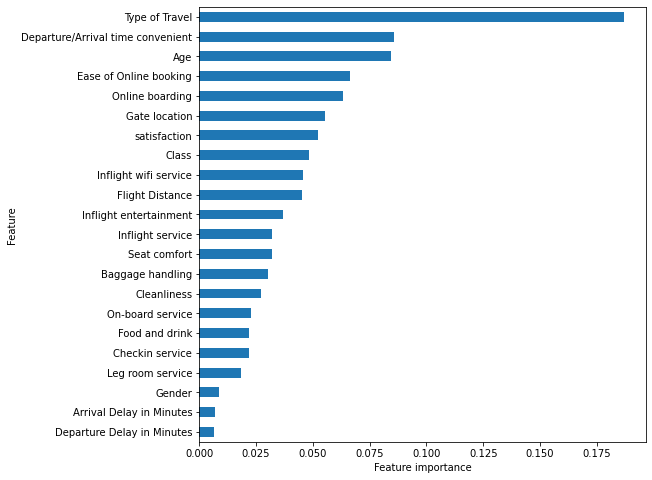

In [27]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=test.columns)
plt.figure(figsize=(8, 8))
print(Series_feat_imp.sort_values(ascending=False))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [28]:
for a in range(10):
  importanceTable[a+1][importanceindex[importancetableIndex]] = Series_feat_imp.sort_values(ascending=False).index[a]
importancetableIndex = importancetableIndex+1
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 피어슨 상관계수 도출

데이터를 가지치기 하기위해 피어슨 상관계수를 도출하고 낮은 계수를 쳐내보도록 한다.

다음과 같이 정의된 ρ=ρ(X,Y) 를 피어슨 상관계수(pearson correlation coefficient)라고 한다.
$$ ρ=Cov(X,Y)σXσY=σXYσXσY$$
$$−1≤ρ≤1Cov(X,Y) $$
를 X와 Y의 공분산(covariance)라 한다.
$$Cov(X,Y)=E[(X−μX)(Y−μY)]=E(XY)−μXμYE(XY)=μXμY+ρσXσY$$
X와 Y가 독립이면 상관계수는 0이된다.하지만 상관계수가 0이라고 X와 Y가 독립인것은 아니다.

값이 0에 수렴할수록 상관관계가 낮으며 절댓값이 높을수록 상관관계가 높다.
값이 높게 되면 양의 상관관계가 높고 값이 낮다면 음의 상관관계가 높다.



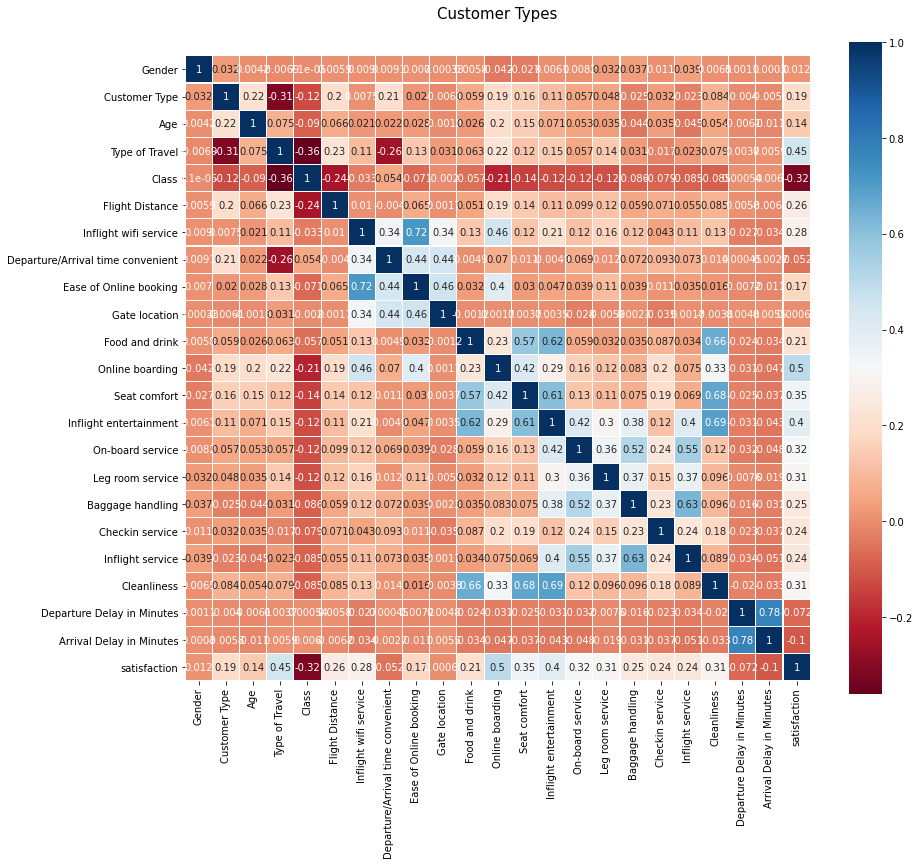

In [29]:
heatmap_data = train[train.columns]
plt.figure(figsize=(14, 12))
colormap = plt.cm.RdBu
plt.title('Customer Types', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 10})

del heatmap_data

# 데이터 분석
Class와 데이터들간의 상관관계를 아래와 같이 볼 수 있다.
클래스 자체를 제외하고 매우 높은 상관관계나 매우 낮은 상관관계는 찾을 수 없다.
하지만 특정값이 연관이 있음을 도출 할 수 있다.

# 피터슨 상관 관계 가지치기

음수를 고려하여 절댓값의 평균을 계산하고 이 값들 미만인 데이터를 제거 하여 속도를 개선하였다.<br>
데이터를 가지칠 경우 정확도가 줄어드나 속도가 개선되는 점을 볼 수 있다.

In [30]:
Class = train.corrwith(train['Customer Type']).sort_values()

In [31]:
# train.drop(['Checkin service','Gender','Ease of Online booking','Inflight service','Inflight wifi service','Baggage handling','Gate location', 'Arrival Delay in Minutes', 'Departure Delay in Minutes',  'Inflight wifi service','Leg room service','On-board service','Food and drink','Cleanliness','Inflight entertainment'], axis=1, inplace=True)
# test.drop(['Checkin service','Gender','Ease of Online booking','Inflight service','Inflight wifi service','Baggage handling','Gate location', 'Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Inflight wifi service','Leg room service','On-board service','Food and drink','Cleanliness','Inflight entertainment'], axis=1, inplace=True)
# 위의 것들을 자동화하여 아래와 같이 코드를 작성함

In [32]:
# Customer Type는 계수가 1이므로 제거하여 평균치가 올라가는 것을 막는다.
Class = Class.drop(["Customer Type"])

In [33]:
# 가중치
mean = 0
for a in Class:
  mean = mean + abs(a)
mean = mean/Class.count()
print("평균치 :" + str(mean))

평균치 :0.09555325579400309


In [34]:
Class.sort_values(ascending=False)

Series_feat_imp = Series(abs(Class.values), index=Class.index)

In [35]:
print(Series_feat_imp.sort_values(ascending=False))

Type of Travel                       0.308333
Age                                  0.217994
Departure/Arrival time convenient    0.206869
Flight Distance                      0.198664
Online boarding                      0.189262
satisfaction                         0.187638
Seat comfort                         0.159484
Class                                0.122325
Inflight entertainment               0.109930
Cleanliness                          0.083613
Food and drink                       0.059454
On-board service                     0.056560
Leg room service                     0.047868
Checkin service                      0.032177
Gender                               0.031732
Baggage handling                     0.024723
Inflight service                     0.022670
Ease of Online booking               0.019509
Inflight wifi service                0.007543
Gate location                        0.006078
Arrival Delay in Minutes             0.005754
Departure Delay in Minutes        

In [36]:
for a in range(10):
  importanceTable[a+1][importanceindex[0]] = Series_feat_imp.sort_values(ascending=False).index[a]
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
PruningTrain = train.copy()
PruningTest = test.copy()

lists = Class.index
count = -1
for a in Class:
  count = count +1
  if(abs(a)< mean):
    PruningTrain.drop([lists[count]], axis=1, inplace=True)
    PruningTest.drop([lists[count]], axis=1, inplace=True)

In [38]:
PruningTrain.corrwith(train['Customer Type']).index

Index(['Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance',
       'Departure/Arrival time convenient', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'satisfaction'],
      dtype='object')

In [39]:
PruningTrain.dtypes

Customer Type                        int64
Age                                  int64
Type of Travel                       int64
Class                                int64
Flight Distance                      int64
Departure/Arrival time convenient    int64
Online boarding                      int64
Seat comfort                         int64
Inflight entertainment               int64
satisfaction                         int64
dtype: object

In [40]:
PruningTest.dtypes

Age                                  int64
Type of Travel                       int64
Class                                int64
Flight Distance                      int64
Departure/Arrival time convenient    int64
Online boarding                      int64
Seat comfort                         int64
Inflight entertainment               int64
satisfaction                         int64
dtype: object

In [41]:
X_train = PruningTrain.drop('Customer Type', axis=1).values
target_label = PruningTrain['Customer Type'].values
X_test = PruningTest.values
X_train.shape, X_test.shape

((103904, 9), (25976, 9))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_train, target_label, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [43]:
print(abs(PruningTrain.corrwith(train['Customer Type'])).sort_values(ascending=False))

Customer Type                        1.000000
Type of Travel                       0.308333
Age                                  0.217994
Departure/Arrival time convenient    0.206869
Flight Distance                      0.198664
Online boarding                      0.189262
satisfaction                         0.187638
Seat comfort                         0.159484
Class                                0.122325
Inflight entertainment               0.109930
dtype: float64


Type of Travel                       0.197809
Departure/Arrival time convenient    0.149306
Age                                  0.126881
Online boarding                      0.114282
Seat comfort                         0.091434
Inflight entertainment               0.085114
Flight Distance                      0.082327
Class                                0.077854
satisfaction                         0.074992
dtype: float64


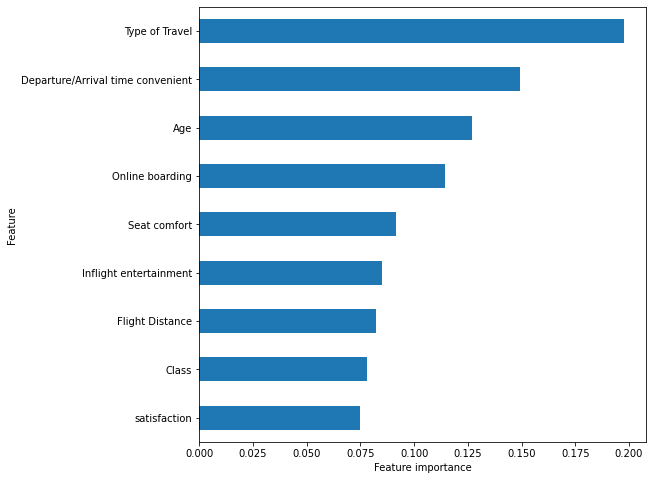

In [44]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=PruningTest.columns)
plt.figure(figsize=(8, 8))
print(Series_feat_imp.sort_values(ascending=False))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [45]:
rpmatrix2 = confusion_matrix(y_test, prediction)
print(rpmatrix2)
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train,y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test,y_test)))
print('{:.4f}% 정밀도로 고객을 예측함'.format(rpmatrix2[1][1]/(rpmatrix2[1][1]+rpmatrix2[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(rpmatrix2[1][1]/(rpmatrix2[1][1]+rpmatrix2[0][1])*100))
# 저장
table["RBPrecision"][index[1]] = rpmatrix2[1][1]/(rpmatrix2[1][1]+rpmatrix2[1][0])*100
table["RBRecall"][index[1]] = rpmatrix2[1][1]/(rpmatrix2[1][1]+rpmatrix2[0][1])*100
table["RBcolumns"][index[1]] = PruningTrain.columns.size-1

[[ 3189   586]
 [  394 16612]]
훈련 세트 정확도: 0.968
테스트 세트 정확도: 0.953
97.6832% 정밀도로 고객을 예측함
96.5926% 재현률로 고객을 예측함


In [46]:
for a in range(Series_feat_imp.sort_values(ascending=False).size):
  importanceTable[a+1][importanceindex[importancetableIndex]] = Series_feat_imp.sort_values(ascending=False).index[a]
importancetableIndex = importancetableIndex+1
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,Type of Travel,Departure/Arrival time convenient,Age,Online boarding,Seat comfort,Inflight entertainment,Flight Distance,Class,satisfaction,NaN
RPmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


가지치기 하기 전 정확도는 98프로에 해당하였으나 가지치기 이후 95프로로 정확도가 낮아짐.

랜덤 포레스트에 사용된 가중치를 보기

모든 데이터를 사용할 경우 정확도는 98.6%에 가깝게 나온다 하지만 이 모델과 달리 칼럼이 많은 모델은 학습에 어려움을 겪을수도 있기 때문에 위와같은 상관계수를 이용하여 가지치기 할 수 있다.
 실제로 가지치기를 하여 정확도가 95%까지 낮아졌지만 계산량은 줄어들었다.<br>

 하지만 피터슨 상관계수가 곧 랜덤 포레스트의 가중치인것은 아니다 위와 같이 피터슨 상관계수에서 Age는 두번째로 중요한 특성으로 나오나 랜덤 포레스트에서는 아니라고 판단하였다.<br>
 하지만 랜덤 포레스트를 돌리기전에 피터슨 상관계수를 통하여 가지치기를 하여 랜덤 포레스트를 돌리는 시간즉 비용을 절약하여 정확도를 끌어낼 수 있다.<br>
 아래는 랜덤포레스트를 이용하여 계산값들을 돌리고 나서 가지치기를 하는 경우이다.

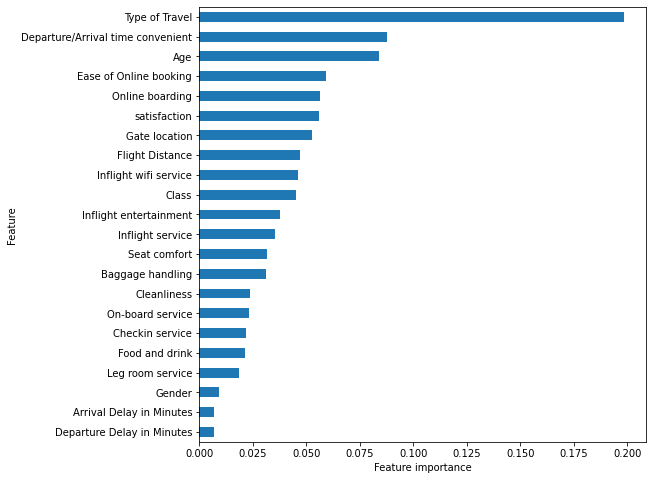

In [47]:
PruningTrain2 = train.copy()
PruningTest2 = test.copy()
X_train = PruningTrain2.drop('Customer Type', axis=1).values
target_label = PruningTrain2['Customer Type'].values
X_test = PruningTest2.values

X_tr, X_te, y_tr, y_te = train_test_split(X_train, target_label, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_te)

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=test.columns)
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [48]:
modelMean = model.feature_importances_.mean()
Series_feat_imp = Series(feature_importance, index=test.columns)

print(modelMean)

lists = Series_feat_imp.index
count = -1
for a in Series_feat_imp:
  count = count +1
  if(abs(a)< modelMean):
    PruningTrain2.drop([lists[count]], axis=1, inplace=True)
    PruningTest2.drop([lists[count]], axis=1, inplace=True)

0.045454545454545456


Type of Travel                       0.196448
Departure/Arrival time convenient    0.145631
Ease of Online booking               0.135597
Gate location                        0.129586
Age                                  0.110880
Online boarding                      0.084527
Flight Distance                      0.072313
satisfaction                         0.067050
Inflight wifi service                0.057967
dtype: float64


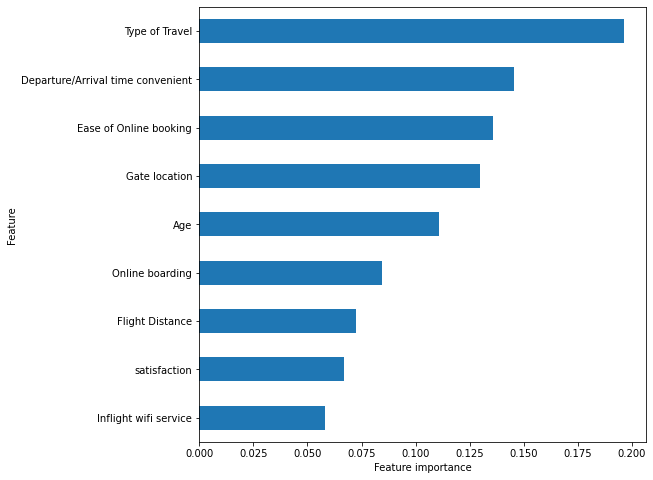

In [49]:
X_train = PruningTrain2.drop('Customer Type', axis=1).values
target_label = PruningTrain2['Customer Type'].values
X_test = PruningTest2.values

X_train, X_test, y_train, y_test = train_test_split(X_train, target_label, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=PruningTest2.columns)
print(Series_feat_imp.sort_values(ascending=False))
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [50]:
# 중요도 저장 및 출력
for a in range(Series_feat_imp.sort_values(ascending=False).size):
  importanceTable[a+1][importanceindex[importancetableIndex]] = Series_feat_imp.sort_values(ascending=False).index[a]
importancetableIndex = importancetableIndex+1
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,Type of Travel,Departure/Arrival time convenient,Age,Online boarding,Seat comfort,Inflight entertainment,Flight Distance,Class,satisfaction,NaN
RPmodel,Type of Travel,Departure/Arrival time convenient,Ease of Online booking,Gate location,Age,Online boarding,Flight Distance,satisfaction,Inflight wifi service,NaN
GBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBdefault,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
rpmatrix3 = confusion_matrix(y_test, prediction)
print(rpmatrix3)
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train,y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test,y_test)))
print('{:.4f}% 정밀도로 고객을 예측함'.format(rpmatrix3[1][1]/(rpmatrix3[1][1]+rpmatrix3[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(rpmatrix3[1][1]/(rpmatrix3[1][1]+rpmatrix3[0][1])*100))

# 저장
table["RBPrecision"]["model"] = rpmatrix3[1][1]/(rpmatrix3[1][1]+rpmatrix3[1][0])*100
table["RBRecall"]["model"] = rpmatrix3[1][1]/(rpmatrix3[1][1]+rpmatrix3[0][1])*100
table["RBcolumns"]["model"] = PruningTrain2.columns.size-1

[[ 3439   336]
 [  217 16789]]
훈련 세트 정확도: 0.979
테스트 세트 정확도: 0.973
98.7240% 정밀도로 고객을 예측함
98.0380% 재현률로 고객을 예측함


In [52]:
display(pd.DataFrame(table))

,RBPrecision,RBRecall,RBf1,RBcolumns,GBPrecision,GBRecall,GBf1,GBcolumns,XGBPrecision,XGBRecall,XGBf1,XGBcolumns
default,99.6354,98.7355,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pearson,97.6832,96.5926,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,98.724,98.038,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 고찰
1. 가지치기를 하지 않을 경우 정밀도 99.62%, 재현율 98.72% <br>
2. 피터슨 계수를 이용한 가지치기를 할 경우 정밀도 97.75%, 재현율 96.53% <br>
3. 랜덤 포레스트를 이용한 가지치기를 할 경우 정밀도 98.88%, 재현율 98.17% 가 나온다 <br>

가지치기의 결과가 다른 이유는 피터슨 계수가 예측값과 연관은 있으나 완전하게 연관 관계를 정의할 수 없다는점이 있다. <br>
하지만 정확도가 조금 떨어진 것으로 보아 어느정도 연관성을 보임을 알 수 있다.  <br>
또한 랜덤포레스트를 이용해서 가지치기를 할 경우에도 비슷하지만 다른 가중치를 지님을 볼 수 있다.  <br>

만약 시간(비용)을 고려하지 않고 정확도가 필요한 경우에는 가지치기를 하지 않고 이용하는 점(1번)이 좋고,  <br>
비용을 고려해야 하나 학습하기 전단계에 가지치기가 필요한 경우(2번)을 이용하면 좋으며 <br>
이미 학습을 했거나, 한번의 학습 시간(비용)을 감당할 수 있을 경우 (3번)을 이용하면 좋다고 생각된다.

# 그레디언트 부스팅

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
target_label = train['Customer Type'].values
gbrtTrain = train.drop('Customer Type', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(gbrtTrain, target_label, random_state=42)
depth = [1,4,7,10]
feature_importance =[]
for a in depth:
  gbrt = GradientBoostingClassifier(random_state=0, max_depth=a, learning_rate=0.1)
  gbrt.fit(X_train,y_train)
  print("\ndepth : {}".format(a))
  prediction = gbrt.predict(X_test)
  rpmatrix = confusion_matrix(y_test, prediction)
  feature_importance.append(gbrt.feature_importances_)
  print(rpmatrix)
  print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train,y_train)*100))
  print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test,y_test)*100))
  print('{:.4f}% 정밀도로 고객을 예측함'.format(rpmatrix[1][1]/(rpmatrix[1][1]+rpmatrix[1][0])*100))
  print('{:.4f}% 재현률로 고객을 예측함'.format(rpmatrix[1][1]/(rpmatrix[1][1]+rpmatrix[0][1])*100))


depth : 1
[[ 2812  1898]
 [  616 20650]]
훈련 세트 정확도: 90.540
테스트 세트 정확도: 90.322
97.1034% 정밀도로 고객을 예측함
91.5824% 재현률로 고객을 예측함

depth : 4
[[ 4319   391]
 [  178 21088]]
훈련 세트 정확도: 97.944
테스트 세트 정확도: 97.810
99.1630% 정밀도로 고객을 예측함
98.1796% 재현률로 고객을 예측함

depth : 7
[[ 4476   234]
 [   86 21180]]
훈련 세트 정확도: 99.174
테스트 세트 정확도: 98.768
99.5956% 정밀도로 고객을 예측함
98.9073% 재현률로 고객을 예측함

depth : 10
[[ 4490   220]
 [   87 21179]]
훈련 세트 정확도: 99.861
테스트 세트 정확도: 98.818
99.5909% 정밀도로 고객을 예측함
98.9719% 재현률로 고객을 예측함


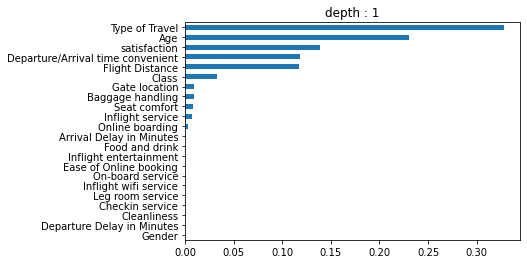

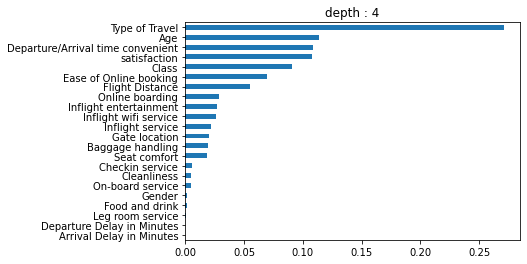

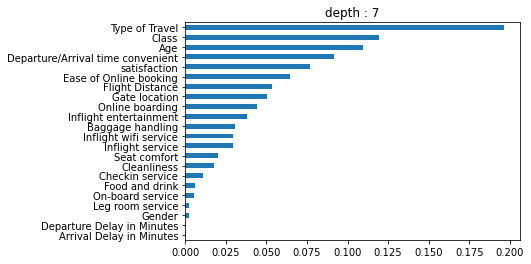

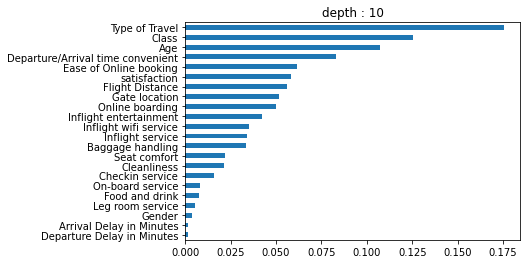

In [54]:
for a in range(4):
  Series_feat_imp = Series(feature_importance[a], index=train.drop('Customer Type', axis=1).columns)
  plt.figure()
  plt.title("depth : " + str(depth[a]))
  Series_feat_imp.sort_values(ascending=True).plot.barh()
		

In [55]:
modelMean = model.feature_importances_.mean()
Series_feat_imp = Series(feature_importance[3], index=train.drop('Customer Type', axis=1).columns)
gbPruningTrain = train.copy()
gbPruningTest = test.copy()

lists = Series_feat_imp.index
count = -1
for a in Series_feat_imp:
  count = count +1
  if(abs(a)< modelMean):
    gbPruningTrain.drop([lists[count]], axis=1, inplace=True)
    gbPruningTest.drop([lists[count]], axis=1, inplace=True)

In [56]:
trainAccuracy = []
testAccuracy = []
importence = []
gbmatrixs = []
columsSize = []

# 기본모델
target_label = train['Customer Type'].values
gbrtTrain = train.drop('Customer Type', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(gbrtTrain, target_label, random_state=42)
gbrt1 = GradientBoostingClassifier(random_state=0)
gbrt1.fit(X_train,y_train)
trainAccuracy.append(gbrt1.score(X_train,y_train))
testAccuracy.append(gbrt1.score(X_test,y_test))
importence.append(gbrt1.feature_importances_)
prediction = gbrt1.predict(X_test)
gbmatrixs.append(confusion_matrix(y_test, prediction))
columsSize.append(train.columns.size-1)
gbrtPruningTrain = train.copy()
gbrtPruningTest = test.copy()
gbrtMean = gbrt1.feature_importances_.mean()
gbrtSeries_feat_imp = Series(gbrt1.feature_importances_, index=test.columns)

lists = gbrtSeries_feat_imp.index
count = -1
for a in gbrtSeries_feat_imp:
  count = count +1
  if(abs(a)< gbrtMean):
    gbrtPruningTrain.drop([lists[count]], axis=1, inplace=True)
    gbrtPruningTest.drop([lists[count]], axis=1, inplace=True)

target_label2 = PruningTrain['Customer Type'].values
gbrtTrain2 = PruningTrain.drop('Customer Type', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(gbrtTrain2, target_label2, random_state=42)
gbrt2 = GradientBoostingClassifier(random_state=0)
gbrt2.fit(X_train,y_train)
trainAccuracy.append(gbrt2.score(X_train,y_train))
testAccuracy.append(gbrt2.score(X_test,y_test))
importence.append(gbrt2.feature_importances_)
prediction = gbrt2.predict(X_test)
gbmatrixs.append(confusion_matrix(y_test, prediction))
columsSize.append(PruningTrain.columns.size-1)


target_label3 = gbrtPruningTrain['Customer Type'].values
gbrtTrain3 = gbrtPruningTrain.drop('Customer Type', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(gbrtTrain3, target_label3, random_state=42)
gbrt3 = GradientBoostingClassifier(random_state=0)
gbrt3.fit(X_train,y_train)
trainAccuracy.append(gbrt3.score(X_train,y_train))
testAccuracy.append(gbrt3.score(X_test,y_test))
importence.append(gbrt3.feature_importances_)
columsSize.append(PruningTrain.columns.size)
prediction = gbrt3.predict(X_test)
gbmatrixs.append(confusion_matrix(y_test, prediction))


모든 컬럼
훈련 세트 정확도: 0.964
테스트 세트 정확도: 0.964
[[ 4088   622]
 [  310 20956]]
98.5423% 정밀도로 고객을 예측함
97.1174% 재현률로 고객을 예측함

피터슨 가지치기
훈련 세트 정확도: 0.938
테스트 세트 정확도: 0.936
[[ 3677  1033]
 [  618 20648]]
97.0940% 정밀도로 고객을 예측함
95.2355% 재현률로 고객을 예측함

그래디언트 가지치기
훈련 세트 정확도: 0.911
테스트 세트 정확도: 0.910
[[ 3255  1455]
 [  872 20394]]
95.8996% 정밀도로 고객을 예측함
93.3407% 재현률로 고객을 예측함


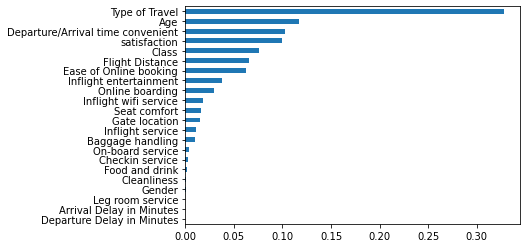

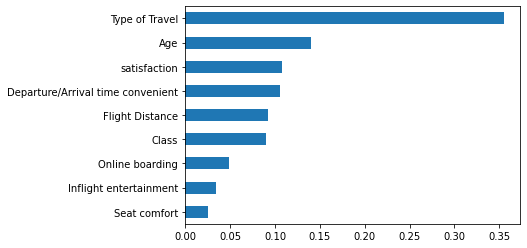

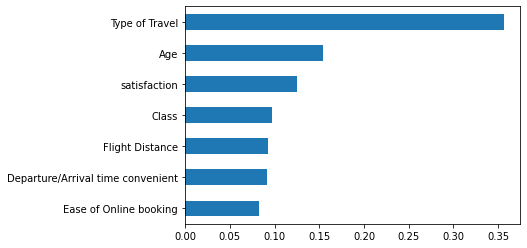

In [57]:
titles = ["모든 컬럼", "피터슨 가지치기", "그래디언트 가지치기"]
indexs = [train.drop('Customer Type', axis=1).columns, PruningTrain.drop('Customer Type', axis=1).columns,gbrtPruningTrain.drop('Customer Type', axis=1).columns]
importancetableIndex =4 
for a in range(3):
  print("\n" + titles[a])
  print("훈련 세트 정확도: {:.3f}".format(trainAccuracy[a]))
  print("테스트 세트 정확도: {:.3f}".format(testAccuracy[a]))
  print(gbmatrixs[a])
  print('{:.4f}% 정밀도로 고객을 예측함'.format(gbmatrixs[a][1][1]/(gbmatrixs[a][1][1]+gbmatrixs[a][1][0])*100))
  print('{:.4f}% 재현률로 고객을 예측함'.format(gbmatrixs[a][1][1]/(gbmatrixs[a][1][1]+gbmatrixs[a][0][1])*100))
  # 저장
  table["GBPrecision"][index[a]] = gbmatrixs[a][1][1]/(gbmatrixs[a][1][1]+gbmatrixs[a][1][0])*100
  table["GBRecall"][index[a]] = gbmatrixs[a][1][1]/(gbmatrixs[a][1][1]+gbmatrixs[a][0][1])*100
  table["GBcolumns"][index[a]] = columsSize[a]
  Series_feat_imp = Series(importence[a], index=indexs[a])
  plt.figure()
  Series_feat_imp.sort_values(ascending=True).plot.barh()
  size = Series_feat_imp.size
  if (size > 10):
    size = 10
  # 중요도 저장 및 출력
  for a in range(size):
    importanceTable[a+1][importanceindex[importancetableIndex]] = Series_feat_imp.sort_values(ascending=False).index[a]
  importancetableIndex = importancetableIndex+1


In [58]:
gbrt3.max_depth

3

In [59]:
display(pd.DataFrame(table))

,RBPrecision,RBRecall,RBf1,RBcolumns,GBPrecision,GBRecall,GBf1,GBcolumns,XGBPrecision,XGBRecall,XGBf1,XGBcolumns
default,99.6354,98.7355,NaN,22,98.5423,97.1174,NaN,22,NaN,NaN,NaN,NaN
Pearson,97.6832,96.5926,NaN,9,97.094,95.2355,NaN,9,NaN,NaN,NaN,NaN
model,98.724,98.038,NaN,9,95.8996,93.3407,NaN,10,NaN,NaN,NaN,NaN


그래디언트 부스팅은 속도가 매우 오래걸림을 알수 있다.
그리고 깊이가 깊어질수록, 정확도가 높아질수록 과적합 이슈에 봉착할 수 있는데 이를 해결한 것이 xgBoost이다.
xgBoost는 사이킷런에서 다루지 않기 떄문에 아래의 과정을 통하여 설치하도록 한다.,

In [60]:
!pip install -q xgboost
import xgboost

In [61]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

target_label = train['Customer Type'].values
xgbrtTrain = train.drop('Customer Type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(xgbrtTrain, target_label, random_state=42)
xgb = XGBClassifier(n_estimators=500,learning_rate=0.1,max_depth=3)
xgb.fit(X_train,y_train)

prediction = xgb.predict(X_test)
xgbmatrix = confusion_matrix(y_test, prediction)
print(xgbmatrix)
print("훈련 세트 정확도: {:.3f}".format(xgb.score(X_train,y_train)*100))
print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test,y_test)*100))
print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))
# 저장
table["XGBPrecision"][index[0]] = xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100
table["XGBRecall"][index[0]] = xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100
table["XGBcolumns"][index[0]] = train.columns.size-1

[[ 4461   249]
 [  115 21151]]
훈련 세트 정확도: 98.727
테스트 세트 정확도: 98.599
99.4592% 정밀도로 고객을 예측함
98.8364% 재현률로 고객을 예측함


# 특성 중요도

In [62]:
xgbrtSeries_feat_imp = Series(xgb.feature_importances_, index=test.columns)
print(xgbrtSeries_feat_imp)

Gender                               0.003557
Age                                  0.132085
Type of Travel                       0.145494
Class                                0.073574
Flight Distance                      0.134196
Inflight wifi service                0.031138
Departure/Arrival time convenient    0.079195
Ease of Online booking               0.054212
Gate location                        0.020569
Food and drink                       0.014716
Online boarding                      0.026540
Seat comfort                         0.031290
Inflight entertainment               0.032705
On-board service                     0.013318
Leg room service                     0.002973
Baggage handling                     0.034443
Checkin service                      0.015570
Inflight service                     0.037299
Cleanliness                          0.018747
Departure Delay in Minutes           0.000770
Arrival Delay in Minutes             0.001123
satisfaction                      

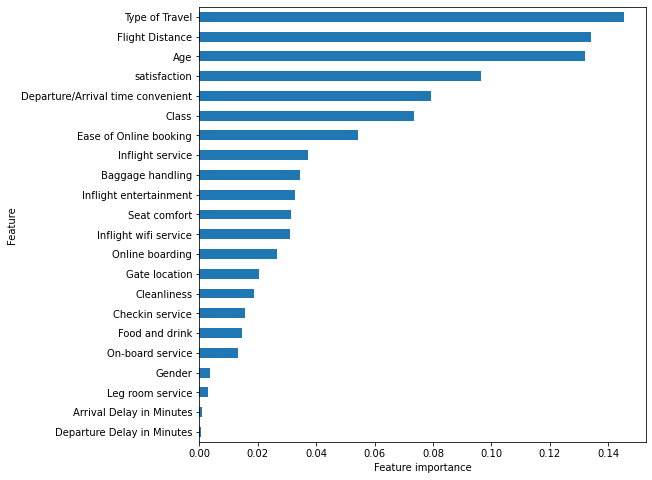

In [63]:
plt.figure(figsize=(8, 8))
xgbrtSeries_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [64]:
# 중요도 저장 및 출력
for a in range(10):
  importanceTable[a+1][importanceindex[importancetableIndex]] = xgbrtSeries_feat_imp.sort_values(ascending=False).index[a]
importancetableIndex = importancetableIndex+1
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,Type of Travel,Departure/Arrival time convenient,Age,Online boarding,Seat comfort,Inflight entertainment,Flight Distance,Class,satisfaction,NaN
RPmodel,Type of Travel,Departure/Arrival time convenient,Ease of Online booking,Gate location,Age,Online boarding,Flight Distance,satisfaction,Inflight wifi service,NaN
GBdefault,Type of Travel,Age,Departure/Arrival time convenient,satisfaction,Class,Flight Distance,Ease of Online booking,Inflight entertainment,Online boarding,Inflight wifi service
GBPearson,Type of Travel,Age,satisfaction,Departure/Arrival time convenient,Flight Distance,Class,Online boarding,Inflight entertainment,Seat comfort,NaN
GBmodel,Type of Travel,Age,satisfaction,Class,Flight Distance,Departure/Arrival time convenient,Ease of Online booking,NaN,NaN,NaN
XGBdefault,Type of Travel,Flight Distance,Age,satisfaction,Departure/Arrival time convenient,Class,Ease of Online booking,Inflight service,Baggage handling,Inflight entertainment
XGBPearson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 가지치기
이미 피터슨을 이용하여 가지치기를 한 데이터들이 있으므로 이를 활용한다.

In [65]:
target_label2 = PruningTrain['Customer Type'].values
xgbrtTrain2 = PruningTrain.drop('Customer Type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(xgbrtTrain2, target_label2, random_state=42)
xgb2 = XGBClassifier(n_estimators=500,learning_rate=0.1,max_depth=3)
xgb2.fit(X_train,y_train)
prediction = xgb2.predict(X_test)
xgbmatrix = confusion_matrix(y_test, prediction)
print(xgbmatrix)
print("훈련 세트 정확도: {:.3f}".format(xgb2.score(X_train,y_train)*100))
print("테스트 세트 정확도: {:.3f}".format(xgb2.score(X_test,y_test)*100))
print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))
# 저장
table["XGBPrecision"][index[1]] = xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100
table["XGBRecall"][index[1]] = xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100
table["XGBcolumns"][index[1]] = PruningTrain.columns.size-1

[[ 3859   851]
 [  491 20775]]
훈련 세트 정확도: 94.966
테스트 세트 정확도: 94.834
97.6912% 정밀도로 고객을 예측함
96.0649% 재현률로 고객을 예측함


In [66]:
xgbrtSeries_feat_imp = Series(xgb2.feature_importances_, index=PruningTrain.drop('Customer Type', axis=1).columns)
print(xgbrtSeries_feat_imp)

Age                                  0.140546
Type of Travel                       0.312749
Class                                0.091839
Flight Distance                      0.138329
Departure/Arrival time convenient    0.056804
Online boarding                      0.042013
Seat comfort                         0.042396
Inflight entertainment               0.040621
satisfaction                         0.134703
dtype: float32


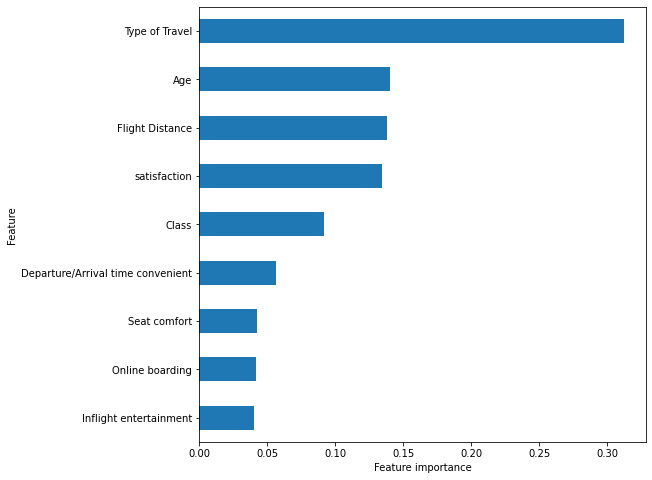

In [67]:
plt.figure(figsize=(8, 8))
xgbrtSeries_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [68]:
# 중요도 저장 및 출력
for a in range(xgbrtSeries_feat_imp.sort_values(ascending=False).size):
  importanceTable[a+1][importanceindex[importancetableIndex]] = xgbrtSeries_feat_imp.sort_values(ascending=False).index[a]
importancetableIndex = importancetableIndex+1
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,Type of Travel,Departure/Arrival time convenient,Age,Online boarding,Seat comfort,Inflight entertainment,Flight Distance,Class,satisfaction,NaN
RPmodel,Type of Travel,Departure/Arrival time convenient,Ease of Online booking,Gate location,Age,Online boarding,Flight Distance,satisfaction,Inflight wifi service,NaN
GBdefault,Type of Travel,Age,Departure/Arrival time convenient,satisfaction,Class,Flight Distance,Ease of Online booking,Inflight entertainment,Online boarding,Inflight wifi service
GBPearson,Type of Travel,Age,satisfaction,Departure/Arrival time convenient,Flight Distance,Class,Online boarding,Inflight entertainment,Seat comfort,NaN
GBmodel,Type of Travel,Age,satisfaction,Class,Flight Distance,Departure/Arrival time convenient,Ease of Online booking,NaN,NaN,NaN
XGBdefault,Type of Travel,Flight Distance,Age,satisfaction,Departure/Arrival time convenient,Class,Ease of Online booking,Inflight service,Baggage handling,Inflight entertainment
XGBPearson,Type of Travel,Age,Flight Distance,satisfaction,Class,Departure/Arrival time convenient,Seat comfort,Online boarding,Inflight entertainment,NaN
XGBmodel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# XGBoosting 가지치기 
XGBoosting를 이미 한번 이용한 이후 가지치기를 한 뒤이다.

In [69]:
xgbrtPruningTrain2 = train.copy()
xgbrtPruningTest2 = test.copy()
xgbrtMean = xgb.feature_importances_.mean()
xgbrtSeries_feat_imp = Series(xgb.feature_importances_, index=test.columns)

# 평균값 산출
lists = xgbrtSeries_feat_imp.index
count = -1
for a in xgbrtSeries_feat_imp:
  count = count +1
  if(a< xgbrtMean):
    xgbrtPruningTrain2.drop([lists[count]], axis=1, inplace=True)
    xgbrtPruningTest2.drop([lists[count]], axis=1, inplace=True)
print(xgbrtPruningTrain2.columns)
print("평균 : {}".format(xgbrtMean))

Index(['Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'satisfaction'],
      dtype='object')
평균 : 0.045454543083906174


In [70]:
target_label3 = xgbrtPruningTrain2['Customer Type'].values
xgbrtTrain3 = xgbrtPruningTrain2.drop('Customer Type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(xgbrtTrain3, target_label3, random_state=42)
xgb3 = XGBClassifier(n_estimators=500,learning_rate=0.1,max_depth=3)
xgb3.fit(X_train,y_train)
prediction = xgb3.predict(X_test)
xgbmatrix = confusion_matrix(y_test, prediction)
print(xgbmatrix)
print("훈련 세트 정확도: {:.3f}".format(xgb3.score(X_train,y_train)*100))
print("테스트 세트 정확도: {:.3f}".format(xgb3.score(X_test,y_test)*100))
print('{:.4f}% 정밀도로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100))
print('{:.4f}% 재현률로 고객을 예측함'.format(xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100))
print('{} 개의 컬럼 보유'.format(xgbrtPruningTrain2.drop('Customer Type', axis=1).columns.size))
# 저장
table["XGBPrecision"][index[2]] = xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[1][0])*100
table["XGBRecall"][index[2]] = xgbmatrix[1][1]/(xgbmatrix[1][1]+xgbmatrix[0][1])*100
table["XGBcolumns"][index[2]] = xgbrtPruningTrain2.columns.size-1

[[ 3403  1307]
 [  887 20379]]
훈련 세트 정확도: 91.608
테스트 세트 정확도: 91.554
95.8290% 정밀도로 고객을 예측함
93.9731% 재현률로 고객을 예측함
7 개의 컬럼 보유


In [71]:
xgbrtSeries_feat_imp = Series(xgb3.feature_importances_, index=xgbrtPruningTrain2.drop('Customer Type', axis=1).columns)
print(xgbrtSeries_feat_imp)

Age                                  0.115845
Type of Travel                       0.442411
Class                                0.083151
Flight Distance                      0.088913
Departure/Arrival time convenient    0.052110
Ease of Online booking               0.058844
satisfaction                         0.158726
dtype: float32


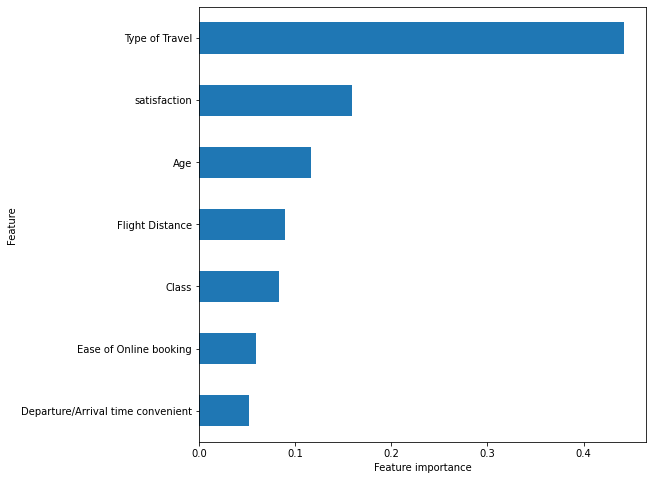

In [72]:
plt.figure(figsize=(8, 8))
xgbrtSeries_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [73]:
# 중요도 저장 및 출력
for a in range(xgbrtSeries_feat_imp.sort_values(ascending=False).size):
  importanceTable[a+1][importanceindex[importancetableIndex]] = xgbrtSeries_feat_imp.sort_values(ascending=False).index[a]
importancetableIndex = importancetableIndex+1
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,Type of Travel,Departure/Arrival time convenient,Age,Online boarding,Seat comfort,Inflight entertainment,Flight Distance,Class,satisfaction,NaN
RPmodel,Type of Travel,Departure/Arrival time convenient,Ease of Online booking,Gate location,Age,Online boarding,Flight Distance,satisfaction,Inflight wifi service,NaN
GBdefault,Type of Travel,Age,Departure/Arrival time convenient,satisfaction,Class,Flight Distance,Ease of Online booking,Inflight entertainment,Online boarding,Inflight wifi service
GBPearson,Type of Travel,Age,satisfaction,Departure/Arrival time convenient,Flight Distance,Class,Online boarding,Inflight entertainment,Seat comfort,NaN
GBmodel,Type of Travel,Age,satisfaction,Class,Flight Distance,Departure/Arrival time convenient,Ease of Online booking,NaN,NaN,NaN
XGBdefault,Type of Travel,Flight Distance,Age,satisfaction,Departure/Arrival time convenient,Class,Ease of Online booking,Inflight service,Baggage handling,Inflight entertainment
XGBPearson,Type of Travel,Age,Flight Distance,satisfaction,Class,Departure/Arrival time convenient,Seat comfort,Online boarding,Inflight entertainment,NaN
XGBmodel,Type of Travel,satisfaction,Age,Flight Distance,Class,Ease of Online booking,Departure/Arrival time convenient,NaN,NaN,NaN


In [74]:
display(pd.DataFrame(table))

,RBPrecision,RBRecall,RBf1,RBcolumns,GBPrecision,GBRecall,GBf1,GBcolumns,XGBPrecision,XGBRecall,XGBf1,XGBcolumns
default,99.6354,98.7355,NaN,22,98.5423,97.1174,NaN,22,99.4592,98.8364,NaN,22
Pearson,97.6832,96.5926,NaN,9,97.094,95.2355,NaN,9,97.6912,96.0649,NaN,9
model,98.724,98.038,NaN,9,95.8996,93.3407,NaN,10,95.829,93.9731,NaN,7


#f1
Precision	과 RBRecall을 보니 각각 크기가 다르기 때문에 어느것이 성능이 좋다 찾기 어려워 비교할 방법을 찾아보니 f1을 찾게 되었다.
$$f1 = {2 \times Precision \times Recall \over Precision +Recall}$$
이는 Precision 과 Recall의 조화평균을 계산한 값인데 이미 위에서 구했으므로 아래와 같은 계산 공식을 더한다.

In [75]:
# f1계산
f1s = []
for a in range(3):
  for b in range(3):
    table[column[a*4+2]][index[b]] = (table[column[a*4+1]][index[b]]*table[column[a*4]][index[b]]*2)/(table[column[a*4+1]][index[b]]+table[column[a*4]][index[b]])
    f1s.append(table[column[a*4+2]][index[b]])

In [76]:
display(pd.DataFrame(table))

,RBPrecision,RBRecall,RBf1,RBcolumns,GBPrecision,GBRecall,GBf1,GBcolumns,XGBPrecision,XGBRecall,XGBf1,XGBcolumns
default,99.6354,98.7355,99.1834,22,98.5423,97.1174,97.8247,22,99.4592,98.8364,99.1469,22
Pearson,97.6832,96.5926,97.1348,9,97.094,95.2355,96.1557,9,97.6912,96.0649,96.8712,9
model,98.724,98.038,98.3798,9,95.8996,93.3407,94.6028,10,95.829,93.9731,94.892,7


# 결과 고찰
정밀도와 재현율의 조화 평균인 f1점수를 비교하면 기본값인 랜덤 포레스트가 가장 점수가 잘 나왔다.

가지치기를 한 모델도 살펴보니 랜덤 포레스트가 잘 나왔는데 더욱 정밀하게 하고싶으면 각 모델의 파라미터를 조절하여 올릴 수 있다.
이번에는 파라미터를 동일하게 하여 각 모델의 성능을 비교해보기 위함이므로 디폴트 값을 사용하였다.



In [77]:
display(pd.DataFrame(importanceTable))

,1,2,3,4,5,6,7,8,9,10
Peterson,Type of Travel,Age,Departure/Arrival time convenient,Flight Distance,Online boarding,satisfaction,Seat comfort,Class,Inflight entertainment,Cleanliness
RPdefault,Type of Travel,Departure/Arrival time convenient,Age,Ease of Online booking,Online boarding,Gate location,satisfaction,Class,Inflight wifi service,Flight Distance
RPPearson,Type of Travel,Departure/Arrival time convenient,Age,Online boarding,Seat comfort,Inflight entertainment,Flight Distance,Class,satisfaction,NaN
RPmodel,Type of Travel,Departure/Arrival time convenient,Ease of Online booking,Gate location,Age,Online boarding,Flight Distance,satisfaction,Inflight wifi service,NaN
GBdefault,Type of Travel,Age,Departure/Arrival time convenient,satisfaction,Class,Flight Distance,Ease of Online booking,Inflight entertainment,Online boarding,Inflight wifi service
GBPearson,Type of Travel,Age,satisfaction,Departure/Arrival time convenient,Flight Distance,Class,Online boarding,Inflight entertainment,Seat comfort,NaN
GBmodel,Type of Travel,Age,satisfaction,Class,Flight Distance,Departure/Arrival time convenient,Ease of Online booking,NaN,NaN,NaN
XGBdefault,Type of Travel,Flight Distance,Age,satisfaction,Departure/Arrival time convenient,Class,Ease of Online booking,Inflight service,Baggage handling,Inflight entertainment
XGBPearson,Type of Travel,Age,Flight Distance,satisfaction,Class,Departure/Arrival time convenient,Seat comfort,Online boarding,Inflight entertainment,NaN
XGBmodel,Type of Travel,satisfaction,Age,Flight Distance,Class,Ease of Online booking,Departure/Arrival time convenient,NaN,NaN,NaN


# 특성 고찰
피터슨과 각 모델의 가중치를 볼때 
Type of Travel은 모두 동일하게 최우선으로 적용되었다.
하지만 다른 수치들은 조금씩 차이가 남을 볼수있다.
피터슨에서 나온 2,3번인 Age와 Departure/Arrival time convenient는 2~4에서 비슷하게 이동하나 4번인 Flight Distance 부터는 어디로 이동할지 가늠할 수 없었다.


이는 피터슨이 각 모델에 영향을 어느정도 주는 수치로 볼 수 있으나 절대적인 수치가 아님을 알 수 있었다.